In [1]:
!pip install huggingface_hub(cli)
!pip install utilsforecast
!pip install praxis
!pip install paxml
!pip install jax[cuda12]==0.4.26
!pip install einshape
!pip install timesfm[pax]

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `pip install huggingface_hub(cli)'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 41.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is still looking at multiple versions of praxis to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install praxis==0.1, praxis==0.2.0, praxis==0.2.1, praxis==0.3.0, praxis==0.4.0, praxis==1.0.0, praxis==1.1.0, praxis==1.2.0, praxis==1.3.0, praxis==1.3.1 and pra

In [2]:
import timesfm
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0].


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7968 entries, 1993-08-12 00:00:00-04:00 to 2025-04-07 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          7968 non-null   float64
 1   High          7968 non-null   float64
 2   Low           7968 non-null   float64
 3   Close         7968 non-null   float64
 4   Volume        7968 non-null   int64  
 5   Dividends     7968 non-null   float64
 6   Stock Splits  7968 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 498.0 KB
                            ds       Open unique_id
0    1993-08-12 00:00:00-04:00   2.790387       EQR
1    1993-08-13 00:00:00-04:00   2.742279       EQR
2    1993-08-16 00:00:00-04:00   2.670113       EQR
3    1993-08-17 00:00:00-04:00   2.694167       EQR
4    1993-08-18 00:00:00-04:00   2.706195       EQR
...                        ...        ...       ...
7963 2025-04-01 00:00:00-04:00  71.580002  

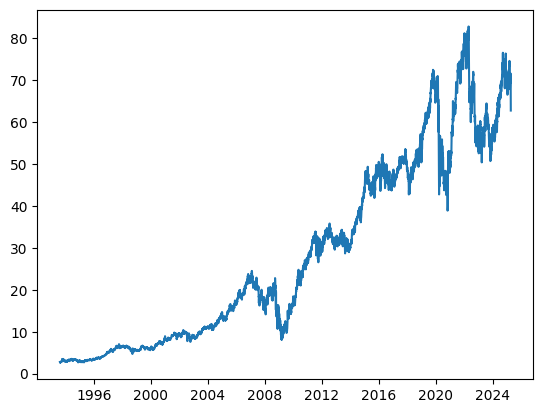

In [3]:
eqr = yf.Ticker("EQR")
df = eqr.history(period="max")
df.info()

df = df.reset_index()
df.rename(columns={'Date': 'ds'}, inplace=True)

df = df[['ds', 'Open']]

df['unique_id']='EQR'

plt.plot(df['ds'], df['Open'])

print(df)

In [4]:
train_end = round(len(df) * 0.9)

train = df[:train_end]
test = df[train_end:]

# Upewnij się, że kolumna 'ds' jest datetime
df['ds'] = pd.to_datetime(df['ds'])

# Pobierz datę z kolumny 'ds' zamiast z indeksu:
start_date = df['ds'].iloc[train_end]
date_list = pd.date_range(start_date, periods=11, freq="30d").tolist()
print(date_list)

[Timestamp('2022-02-02 00:00:00-0500', tz='America/New_York'), Timestamp('2022-03-04 00:00:00-0500', tz='America/New_York'), Timestamp('2022-04-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-05-03 00:00:00-0400', tz='America/New_York'), Timestamp('2022-06-02 00:00:00-0400', tz='America/New_York'), Timestamp('2022-07-02 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-01 00:00:00-0400', tz='America/New_York'), Timestamp('2022-08-31 00:00:00-0400', tz='America/New_York'), Timestamp('2022-09-30 00:00:00-0400', tz='America/New_York'), Timestamp('2022-10-30 00:00:00-0400', tz='America/New_York'), Timestamp('2022-11-29 00:00:00-0500', tz='America/New_York')]


In [27]:
tfm_eqr = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=32,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2304,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
d0 = date_list[0]
d1 = date_list[1]
d2 = date_list[2]

print(d0, d1)

subtest0 = test[(test['ds'] >= d0) & (test['ds'] < d1)]
subtest1 = test[(test['ds'] >= d1) & (test['ds'] < d2)]
print(subtest0.info())
print(subtest0)

print(subtest1.info())
print(subtest1)

2022-02-02 00:00:00-05:00 2022-03-04 00:00:00-05:00
<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 7171 to 7191
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype                           
---  ------     --------------  -----                           
 0   ds         21 non-null     datetime64[ns, America/New_York]
 1   Open       21 non-null     float64                         
 2   unique_id  21 non-null     object                          
dtypes: datetime64[ns, America/New_York](1), float64(1), object(1)
memory usage: 672.0+ bytes
None
                            ds       Open unique_id
7171 2022-02-02 00:00:00-05:00  78.141337       EQR
7172 2022-02-03 00:00:00-05:00  80.983318       EQR
7173 2022-02-04 00:00:00-05:00  80.129843       EQR
7174 2022-02-07 00:00:00-05:00  79.082787       EQR
7175 2022-02-08 00:00:00-05:00  79.073997       EQR
7176 2022-02-09 00:00:00-05:00  77.877376       EQR
7177 2022-02-10 00:00:00-05:00  78.343694       EQR
7178 2

In [14]:
train_df = df[df['ds'] < d1].copy()
train_df

,ds,Open,unique_id
0,1993-08-12 00:00:00-04:00,2.790387,EQR
1,1993-08-13 00:00:00-04:00,2.742279,EQR
2,1993-08-16 00:00:00-04:00,2.670113,EQR
3,1993-08-17 00:00:00-04:00,2.694167,EQR
4,1993-08-18 00:00:00-04:00,2.706195,EQR
...,...,...,...
7187,2022-02-25 00:00:00-05:00,75.114587,EQR
7188,2022-02-28 00:00:00-05:00,75.686495,EQR
7189,2022-03-01 00:00:00-05:00,75.202569,EQR
7190,2022-03-02 00:00:00-05:00,73.935554,EQR


In [15]:
forecast_df = tfm_eqr.forecast_on_df(
      inputs=train_df,
      freq="1D",  # day
      value_name="Open",
      num_jobs=-1,
  )

print(forecast_df.head(5))
print(forecast_df.tail(5))

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
  unique_id                        ds    timesfm  timesfm-q-0.1  \
0       EQR 2022-03-04 00:00:00-05:00  75.869919      74.407509   
1       EQR 2022-03-05 00:00:00-05:00  75.880859      74.090317   
2       EQR 2022-03-06 00:00:00-05:00  75.805038      73.632080   
3       EQR 2022-03-07 00:00:00-05:00  75.811874      73.379227   
4       EQR 2022-03-08 00:00:00-05:00  75.884659      73.200684   
5       EQR 2022-03-09 00:00:00-05:00  75.823814      72.823814   
6       EQR 2022-03-10 00:00:00-05:00  75.665283      72.456329   
7       EQR 2022-03-11 00:00:00-05:00  75.745132      72.340683   
8       EQR 2022-03-12 00:00:00-05:00  75.706039      72.082458   
9       EQR 2022-03-13 00:00:00-05:00  75.641907      71.744461   

   timesfm-q-0.2  timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  \
0      74.974586      75.309647      75.602951      75.869919      76.132187   


In [17]:
forecast_subset = forecast_df[forecast_df['ds'].dt.date.isin(subtest1['ds'].dt.date)]
print(forecast_subset.head(5), forecast_subset.tail(5))
mape=mean_absolute_percentage_error(subtest1['Open'], forecast_subset['timesfm'])
print(mape)

   unique_id                        ds    timesfm  timesfm-q-0.1  \
0        EQR 2022-03-04 00:00:00-05:00  75.869919      74.407509   
3        EQR 2022-03-07 00:00:00-05:00  75.811874      73.379227   
4        EQR 2022-03-08 00:00:00-05:00  75.884659      73.200684   
5        EQR 2022-03-09 00:00:00-05:00  75.823814      72.823814   
6        EQR 2022-03-10 00:00:00-05:00  75.665283      72.456329   
7        EQR 2022-03-11 00:00:00-05:00  75.745132      72.340683   
10       EQR 2022-03-14 01:00:00-04:00  75.486649      71.329781   
11       EQR 2022-03-15 01:00:00-04:00  75.373062      71.032372   
12       EQR 2022-03-16 01:00:00-04:00  75.339584      70.813339   
13       EQR 2022-03-17 01:00:00-04:00  75.165939      70.465775   
14       EQR 2022-03-18 01:00:00-04:00  75.001724      70.160591   
17       EQR 2022-03-21 01:00:00-04:00  74.953079      69.445122   
18       EQR 2022-03-22 01:00:00-04:00  74.862228      69.240936   
19       EQR 2022-03-23 01:00:00-04:00  74.88809

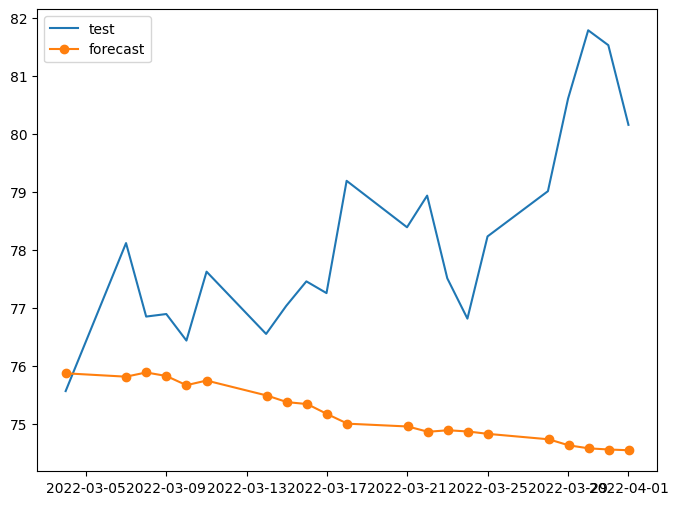

In [22]:
plt.figure(figsize=(8,6))
plt.plot(subtest1['ds'], subtest1['Open'], label="test")
plt.plot(forecast_subset['ds'], forecast_subset['timesfm'], label="forecast", marker='o')
plt.legend()
plt.show()

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.022410601778673617


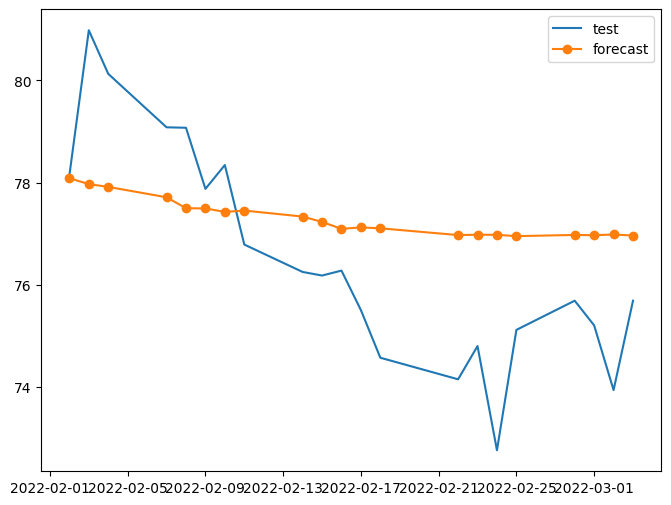

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.03841837916399937


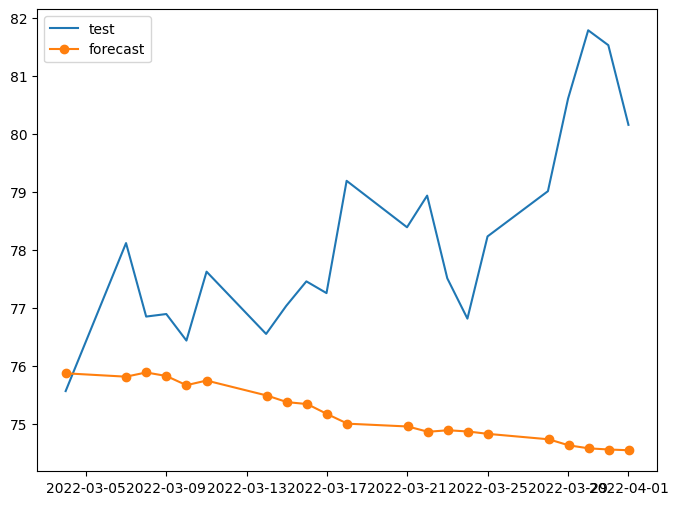

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.019310091180021482


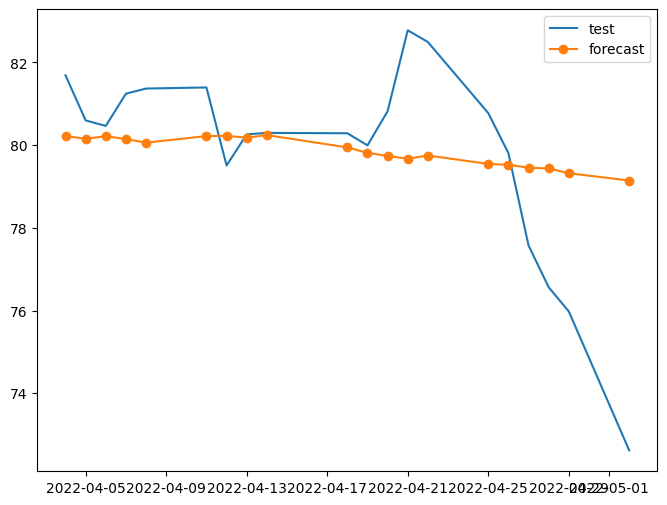

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.0678677469903778


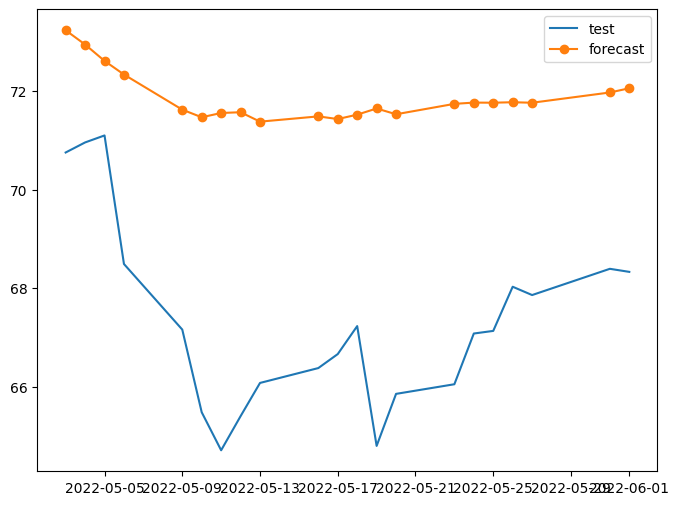

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.08138954722996504


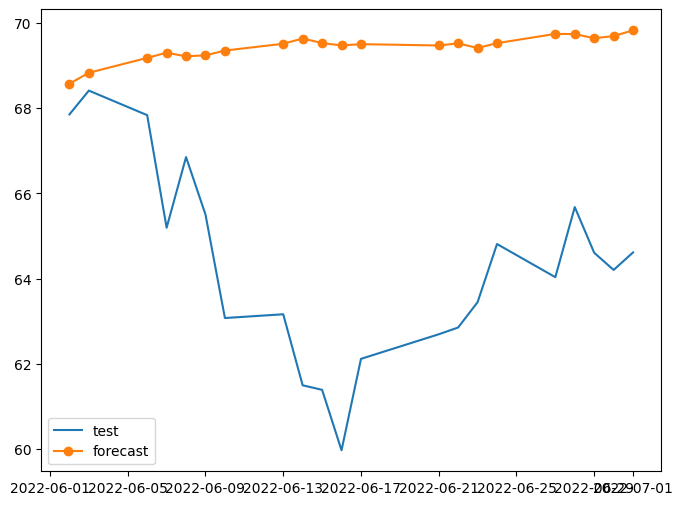

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.01912370719219696


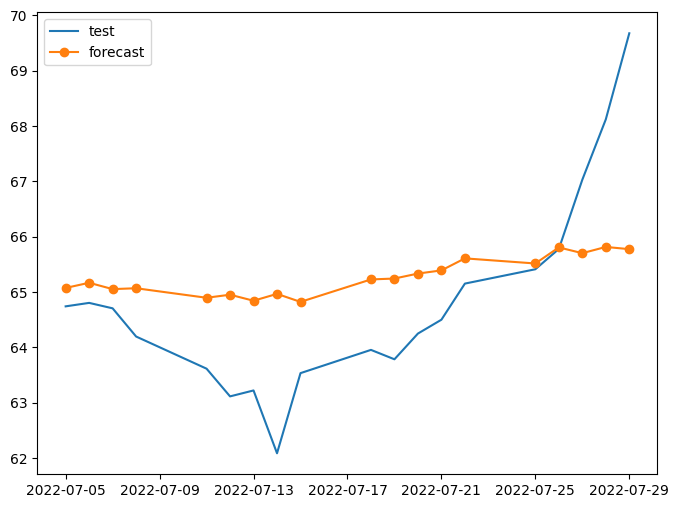

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.028685169455954992


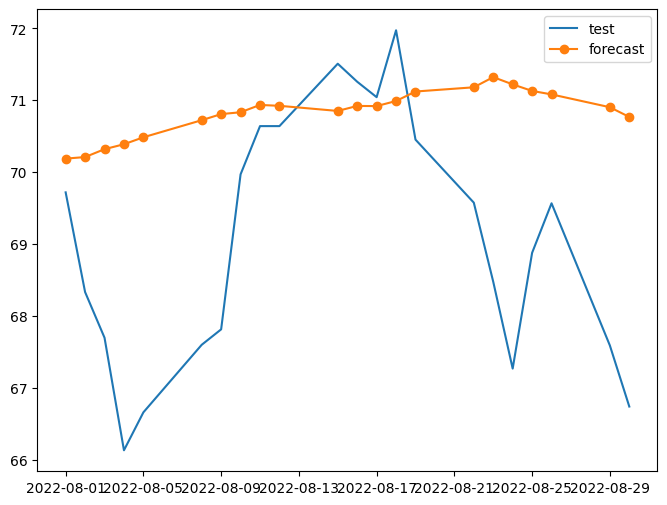

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.037659366530663915


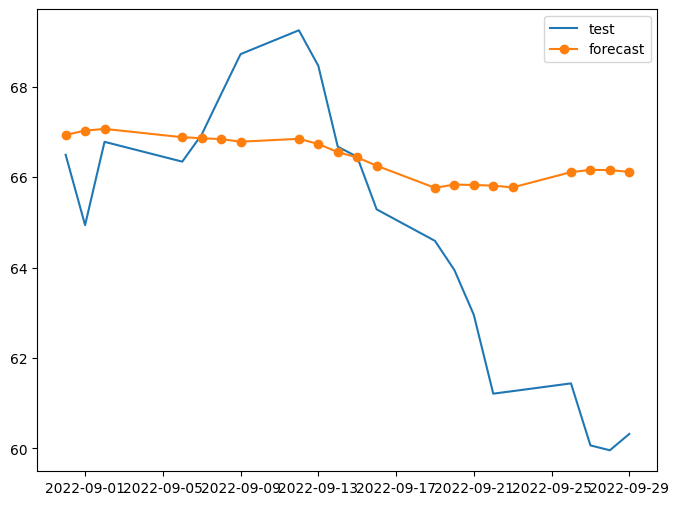

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.05309357597251503


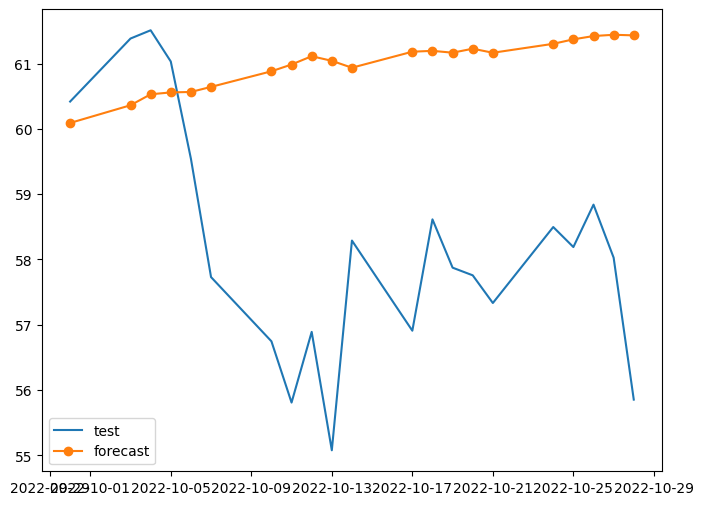

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.015418377509694967


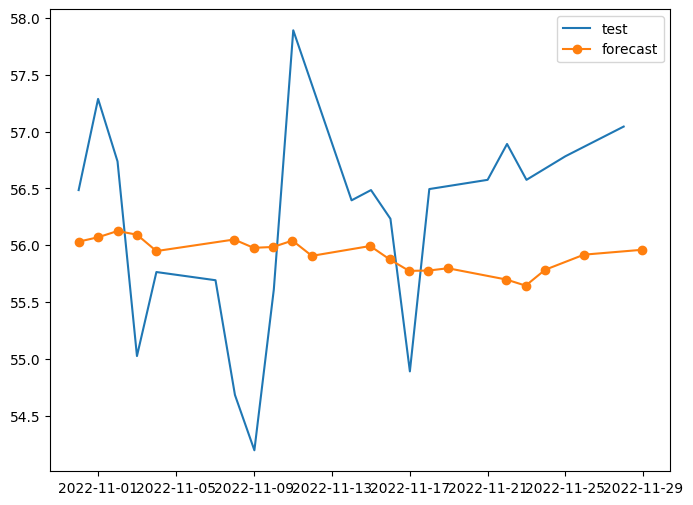

Processing dataframe with multiple processes.
Finished preprocessing dataframe.
Finished forecasting.
MAPE:  0.036999478525047876


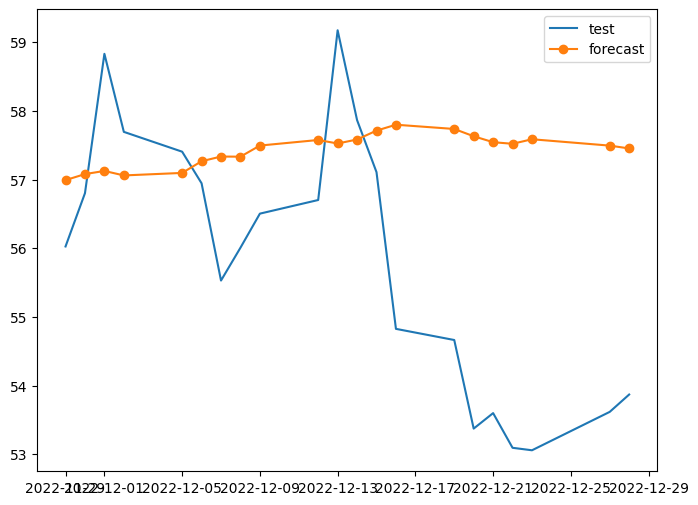

In [28]:
df_forecasts=[]
mapes=[]

for d in date_list:
  train_df = df[df['ds'] < d].copy()
  subtest = test[(test['ds'] >= d) & (test['ds'] < d + pd.Timedelta(days=30))]

  forecast_df = tfm_eqr.forecast_on_df(
      inputs=train_df,
      freq="1D",  # day
      value_name="Open",
      num_jobs=-1,
  )

  df_forecasts.append(forecast_df)
  forecast_subset = forecast_df[forecast_df['ds'].dt.date.isin(subtest['ds'].dt.date)]

  mape=mean_absolute_percentage_error(subtest['Open'], forecast_subset['timesfm'])
  print("MAPE: ", mape)
  mapes.append(mape)

  plt.figure(figsize=(8,6))
  plt.plot(subtest['ds'], subtest['Open'], label="test")
  plt.plot(forecast_subset['ds'], forecast_subset['timesfm'], label="forecast", marker='o')
  plt.legend()
  plt.show()



In [29]:
print("Average MAPE:", sum(mapes)/len(mapes))

Average MAPE: 0.038216003775373736


In [26]:
d2=date_list[2]
train_df = df[df['ds'] < d2].copy()
print(train_df.tail(10))
subtest2 = test[(test['ds'] >= d2) & (test['ds'] < d2 + pd.Timedelta(days=30))]
print(subtest2.head(10))
print(subtest2.tail(5))


                            ds       Open unique_id
7203 2022-03-21 00:00:00-04:00  78.387695       EQR
7204 2022-03-22 00:00:00-04:00  78.933209       EQR
7205 2022-03-23 00:00:00-04:00  77.507816       EQR
7206 2022-03-24 00:00:00-04:00  76.812724       EQR
7207 2022-03-25 00:00:00-04:00  78.229980       EQR
7208 2022-03-28 00:00:00-04:00  79.009795       EQR
7209 2022-03-29 00:00:00-04:00  80.604869       EQR
7210 2022-03-30 00:00:00-04:00  81.783477       EQR
7211 2022-03-31 00:00:00-04:00  81.526482       EQR
7212 2022-04-01 00:00:00-04:00  80.152954       EQR
                            ds       Open unique_id
7213 2022-04-04 00:00:00-04:00  81.686002       EQR
7214 2022-04-05 00:00:00-04:00  80.596007       EQR
7215 2022-04-06 00:00:00-04:00  80.463099       EQR
7216 2022-04-07 00:00:00-04:00  81.242917       EQR
7217 2022-04-08 00:00:00-04:00  81.366988       EQR
7218 2022-04-11 00:00:00-04:00  81.393553       EQR
7219 2022-04-12 00:00:00-04:00  79.506055       EQR
7220 2022-04